In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA


# === Impostazioni iniziali ===
base_dir = './'
strumenti = ['chitarra', 'violino', 'pianoforte', 'viola', 'flauto']

In [2]:
def carica_dataset(split):
    dataframes = []
    for strumento in strumenti:
        filename = f"{strumento}_{split}.csv"
        path = os.path.join(base_dir, split, filename)
        df = pd.read_csv(path)
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

In [3]:
# === Caricamento dati ===
train_df = carica_dataset('train')
val_df = carica_dataset('val')
test_df = carica_dataset('test')

# === Separazione feature e label ===
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

# === Encoding ===
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

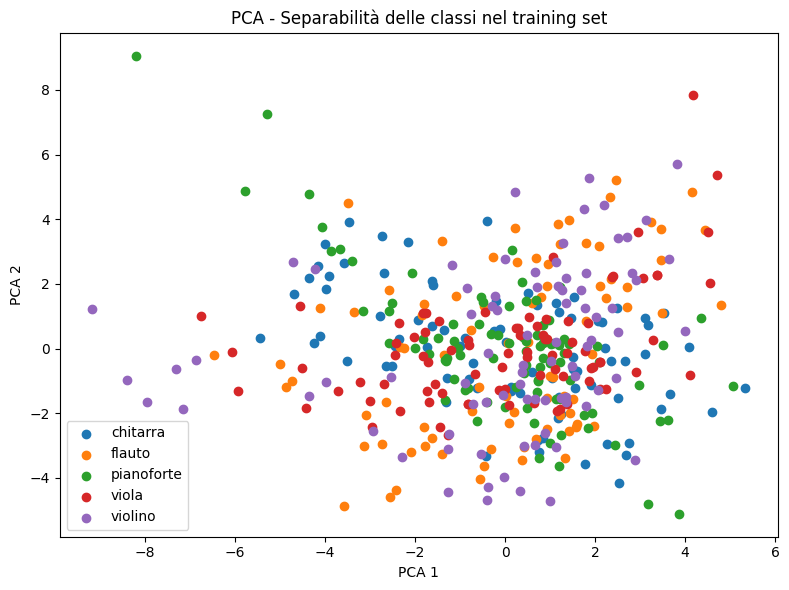

In [ ]:
# Normalizzazione delle feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Visualizzazione PCA
plt.figure(figsize=(8,6))
for i, label in enumerate(label_encoder.classes_):
    plt.scatter(X_pca[y_train_enc == i, 0], X_pca[y_train_enc == i, 1], label=label)
plt.title("PCA - Separabilità delle classi nel training set")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# === Grid Search per XGB ===
xgb_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
}
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_grid = GridSearchCV(xgb_clf, xgb_params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train_enc)

print("Migliori iperparametri XGB:", xgb_grid.best_params_)
best_xgb = xgb_grid.best_estimator_

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_cv_scores = cross_val_score(best_xgb, X_train_scaled, y_train_enc, cv=cv, scoring='accuracy')

print("\n== CROSS VALIDATION ==")
print(f"XGBoost CV Accuracy: {xgb_cv_scores.mean():.3f} ± {xgb_cv_scores.std():.3f}")


# === Valutazione XGB ===
y_val_pred_xgb = best_xgb.predict(X_val_scaled)
y_test_pred_xgb = best_xgb.predict(X_test_scaled)

print("\n== XGBOOST VALIDATION ==")
print(classification_report(y_val_enc, y_val_pred_xgb, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_val_enc, y_val_pred_xgb))

print("\n== XGBOOST TEST ==")
print(classification_report(y_test_enc, y_test_pred_xgb, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test_enc, y_test_pred_xgb))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Migliori iperparametri XGB: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

== CROSS VALIDATION ==
XGBoost CV Accuracy: 0.667 ± 0.034

== XGBOOST VALIDATION ==
              precision    recall  f1-score   support

    chitarra       0.83      0.56      0.67        18
      flauto       0.71      0.67      0.69        18
  pianoforte       0.80      1.00      0.89        20
       viola       0.65      0.55      0.59        20
     violino       0.57      0.72      0.63        18

    accuracy                           0.70        94
   macro avg       0.71      0.70      0.69        94
weighted avg       0.71      0.70      0.70        94

Accuracy: 0.7021276595744681

== XGBOOST TEST ==
              precision    recall  f1-score   support

    chitarra       0.67      0.89      0.76        18
      flauto       0.76      0.72      0.74        18
  pianoforte       0.85      0.58      0.69        19
       viol

In [6]:
# === Grid Search per RandomForest ===
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
}
rf_clf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_clf, rf_params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train_enc)

print("Migliori iperparametri RF:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

rf_cv_scores = cross_val_score(best_rf, X_train_scaled, y_train_enc, cv=cv, scoring='accuracy')
print(f"Random Forest CV Accuracy: {rf_cv_scores.mean():.3f} ± {rf_cv_scores.std():.3f}")


# === Valutazione Random Forest ===
y_val_pred_rf = best_rf.predict(X_val_scaled)
y_test_pred_rf = best_rf.predict(X_test_scaled)

print("\n== RANDOM FOREST VALIDATION ==")
print(classification_report(y_val_enc, y_val_pred_rf, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_val_enc, y_val_pred_rf))

print("\n== RANDOM FOREST TEST ==")
print(classification_report(y_test_enc, y_test_pred_rf, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test_enc, y_test_pred_rf))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Migliori iperparametri RF: {'max_depth': None, 'n_estimators': 200}
Random Forest CV Accuracy: 0.765 ± 0.032

== RANDOM FOREST VALIDATION ==
              precision    recall  f1-score   support

    chitarra       0.88      0.83      0.86        18
      flauto       0.82      0.78      0.80        18
  pianoforte       0.87      1.00      0.93        20
       viola       0.89      0.85      0.87        20
     violino       0.83      0.83      0.83        18

    accuracy                           0.86        94
   macro avg       0.86      0.86      0.86        94
weighted avg       0.86      0.86      0.86        94

Accuracy: 0.8617021276595744

== RANDOM FOREST TEST ==
              precision    recall  f1-score   support

    chitarra       0.71      0.83      0.77        18
      flauto       0.83      0.83      0.83        18
  pianoforte       0.85      0.89      0.87        19
       viola       0.78      0.78     

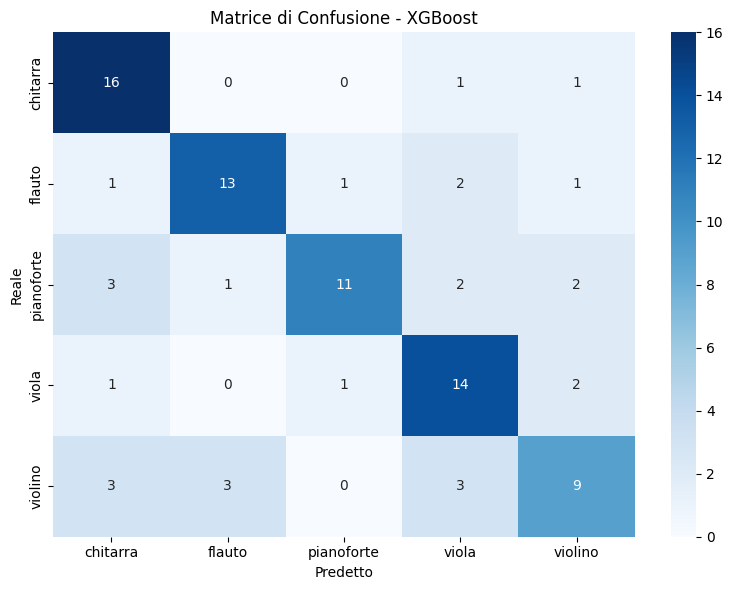

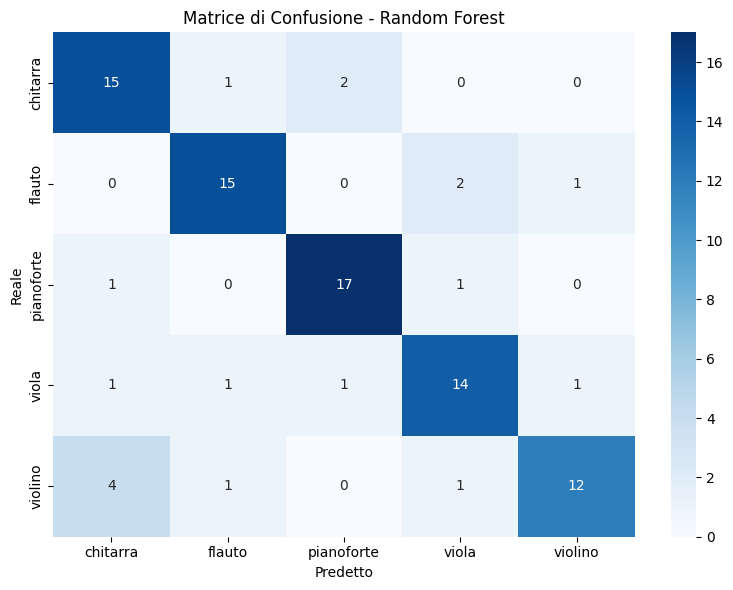

In [9]:
# Confusion Matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
    plt.title(f'Matrice di Confusione - {title}')
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_test_enc, y_test_pred_xgb, "XGBoost")
plot_conf_matrix(y_test_enc, y_test_pred_rf, "Random Forest")

/var/folders/gg/l_gw7m4913xfr53bkqcf741r0000gn/T/ipykernel_63188/603391458.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="Set2")


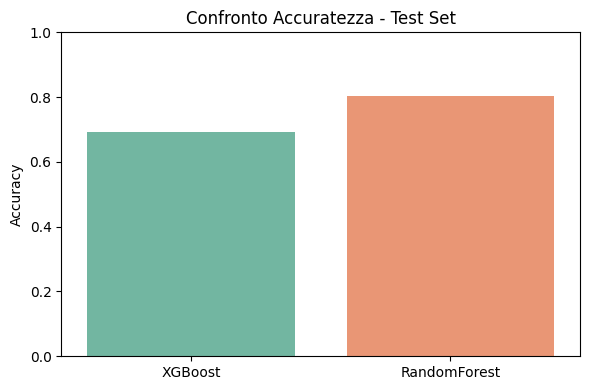

In [10]:
# Accuracy comparison
accuracies = {
    'XGBoost': accuracy_score(y_test_enc, y_test_pred_xgb),
    'RandomForest': accuracy_score(y_test_enc, y_test_pred_rf),
}
plt.figure(figsize=(6, 4))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="Set2")
plt.title("Confronto Accuratezza - Test Set")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()